Build training, validation and testing datasets

In [1]:
import numpy as np
import librosa
import librosa.display as display
import matplotlib.pyplot as plt
import os
import h5py
import time
import wav2mp3

Retrieve all file names

In [2]:
data_path = '../electric_guitar' # location of dataset
genre_path_dict = dict()
label_dict = dict()

for (dirpath, dirnames, filenames) in os.walk(data_path):
    if dirnames:
        for idx, genre in enumerate(dirnames):
            genre_path_dict[genre] = list()
            label_dict[genre] = idx
        continue
    else:
        genre = dirpath.split('/')[-1]
        for au_file in filenames:
            if 'mp3' in au_file:
                current_path = dirpath + '/' + au_file
                genre_path_dict[genre].append(current_path)
            if 'wav' in au_file:
                current_path = dirpath + '/' + au_file
                genre_path_dict[genre].append(current_path)


total_file = sum([len(genre_path_dict[genre]) for genre in genre_path_dict])
total_file

550

Create log-Mel spectrogram

In [3]:
# global varibles:
sr = 16000
cut_time = 0  # throw first and last 10s
cut_wave_length = cut_time * sr
n_ftt = 256
hop = n_ftt // 8

In [4]:
label_dict

{'pop': 0,
 'rock_blues': 1,
 'metal': 2,
 'latin': 3,
 'classical': 4,
 'country_folk': 5,
 'reggae_ska': 6,
 'jazz': 7}

In [5]:
genre_dict = dict()
for key in label_dict:
    genre_dict[label_dict.get(key)] = key

In [6]:
genre_dict

{0: 'pop',
 1: 'rock_blues',
 2: 'metal',
 3: 'latin',
 4: 'classical',
 5: 'country_folk',
 6: 'reggae_ska',
 7: 'jazz'}

In [7]:
genre_path_dict['metal'][3]

'../electric_guitar/metal/metal_2_180BPM 2.wav'

In [8]:
# This is the newer one
# changed to allow, spectrogram size as a input parameter 
def frame_feature_extractor(file_path, size):
    signal, _ = librosa.load(file_path, sr=sr)
    # signal = signal[cut_wave_length: -1 * cut_wave_length] # cut wave length
    
    S = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=size).T
    S = librosa.power_to_db(S)
    if not S.shape[0] % size == 0:
        S = S[:-1 * (S.shape[0] % size)] # divide the mel spectrogram
    chunk_num = int(S.shape[0] / size) # was 64 in previous training
    mel_chunks = np.split(S, chunk_num) # create 128 * 128 data frames
    return mel_chunks, chunk_num

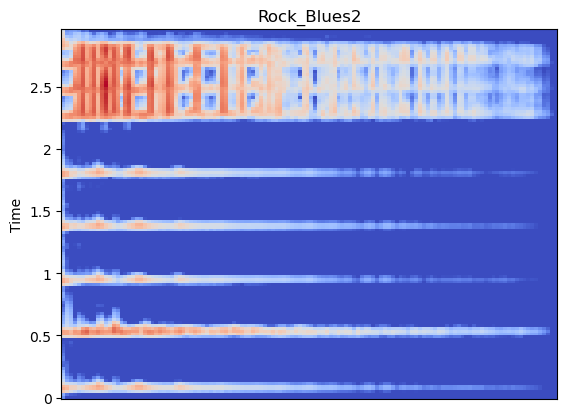

In [9]:
signal, chunk_num = frame_feature_extractor(genre_path_dict['rock_blues'][2],128)
plt.title('Rock_Blues2')
display.specshow(signal[1], y_axis='time')
plt.show()

## Build datasets

In [10]:
def build_tag(genre):
    target = np.zeros(len(label_dict), dtype=int)
    pos = label_dict.get(genre)
    target[pos] = 1
    return target

build_tag('rock_blues').shape

(8,)

## Create separate dataset for each file

In [11]:
data_set_path = '../handmadeDBL_JohnAll_128/' #change for each dataset change

In [12]:
count = 0
file_index = 0
mel_shape = signal[0].shape

for key in label_dict:
    print('deal with {0}'.format(key))
    for file_i, file in enumerate(genre_path_dict.get(key)):
        mel_list, chunk_number = frame_feature_extractor(file,128)
        dataset_name = data_set_path + str(file_index) + '.h5'
        current_dataset = h5py.File(dataset_name, 'a')
        
        current_dataset.create_dataset('mel', shape=(chunk_number, mel_shape[0], mel_shape[1]), dtype=np.float32)
        current_dataset.create_dataset('tag', shape=(chunk_number, 8), dtype=int)   
        
        for i, mel_signal_chunk in enumerate(mel_list):
            current_dataset['tag'][i] = build_tag(key)
            current_dataset['mel'][i] = mel_signal_chunk
            count += 1
        
        print('->{0}'.format(file_i), end='')
        current_dataset.close()
        file_index += 1
        
    print(' ')

print(count)
print(file_index)
    

deal with pop


/Users/seanlevine/opt/anaconda3/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


->0->1->2->3->4->5->6->7->8->9->10->11->12->13->14->15->16->17->18->19->20->21->22->23->24->25->26->27->28->29->30->31->32->33->34->35->36->37->38->39->40->41->42->43->44->45->46->47->48->49->50->51->52->53->54->55->56->57->58->59->60->61->62->63->64->65->66->67->68 
deal with rock_blues
->0->1->2->3->4->5->6->7->8->9->10->11->12->13->14->15->16->17->18->19->20->21->22->23->24->25->26->27->28->29->30->31->32->33->34->35->36->37->38->39->40->41->42->43->44->45->46->47->48->49->50->51->52->53->54->55->56->57->58->59->60->61->62->63->64->65->66->67->68 
deal with metal
->0->1->2->3->4->5->6->7->8->9->10->11->12->13->14->15->16->17->18->19->20->21->22->23->24->25->26->27->28->29->30->31->32->33->34->35->36->37->38->39->40->41->42->43->44->45->46->47->48->49->50->51->52->53->54->55->56->57->58->59->60->61->62->63->64->65->66->67->68 
deal with latin
->0->1->2->3->4->5->6->7->8->9->10->11->12->13->14->15->16->17->18->19->20->21->22->23->24->25->26->27->28->29->30->31->32->33->34->35->36->37-

In [13]:
all_setpath = data_set_path + 'hand_all.h5'
all_dataset = h5py.File(all_setpath, 'a')

In [14]:
# count = 1673 # depends on the previous dataset
all_dataset.create_dataset('mel', shape=(count, mel_shape[0], mel_shape[1]), dtype=np.float32)
all_dataset.create_dataset('tag', shape=(count, 8), dtype=int)   

<HDF5 dataset "tag": shape (3703, 8), type "<i8">

### load data in one set

In [15]:
count = 0
for (dirpath, dirnames, filenames) in os.walk(data_set_path):
    if filenames:
        for set_name in filenames:
            if 'h5' not in set_name or 'all' in set_name:
                continue
            set_path = data_set_path + set_name
            tmp_dataset = h5py.File(set_path, 'r')
            tmp_count = tmp_dataset['mel'].shape[0]
            for i in range(tmp_count):
                all_dataset['mel'][count] = tmp_dataset['mel'][i]
                all_dataset['tag'][count] = tmp_dataset['tag'][i]
                count += 1
            tmp_dataset.close()
all_dataset.close()
print(count)

3703


In [16]:
setpath1 = data_set_path + 'hand_all.h5'
setpath2 = data_set_path + 'all_long.h5'
db1 = h5py.File(setpath1, 'r')
# db2 = h5py.File(setpath2, 'r')
all_chunk = count + 3000

fin_setpath = data_set_path + 'fin_all.h5'
dataset = h5py.File(fin_setpath, 'a')
dataset.create_dataset('mel', shape=(all_chunk, mel_shape[0], mel_shape[1]), dtype=np.float32)
dataset.create_dataset('tag', shape=(all_chunk, 8), dtype=int) 

fin_count = 0
for j in range(count):
    dataset['mel'][fin_count] = db1['mel'][j]
    dataset['tag'][fin_count] = db1['tag'][j]
    fin_count += 1

db1.close()

# for j in range(3000):
#     dataset['mel'][fin_count] = db2['mel'][j]
#     dataset['tag'][fin_count] = db2['tag'][j]
#     fin_count += 1

# db2.close()
dataset.close()
print(fin_count)

3703


## Build Separate Datasets

In [17]:
import random

In [18]:
dataset = h5py.File(setpath1, 'r')

In [19]:
train_file = fin_count * 0.7
valid_file = fin_count * 0.2
test_file = fin_count - int(train_file) - int(valid_file)

In [20]:
# train_set = '../handmadeDBL2/l_train.h5'
# valid_set = '../handmadeDBL2/l_valid.h5'
# test_set = '../handmadeDBL2/l_test.h5'
train_set = data_set_path + 'l_train.h5'
valid_set =  data_set_path + 'l_valid.h5'
test_set =  data_set_path + 'l_test.h5'

In [21]:
files = [int(a) for a in [train_file, valid_file, test_file]]
sets = [train_set, valid_set, test_set]
print(files)

[2592, 740, 371]


### Shuffle and create

In [22]:
idx = [i for i in range(fin_count)]
random.seed(516)
random.shuffle(idx)

In [23]:
train_idx = idx[:files[0]]
valid_idx = idx[files[0]: files[0]+files[1]]
test_idx = idx[-files[2]:]
indices = [train_idx, valid_idx, test_idx]

### Copy

In [24]:
for i, dset in enumerate(sets):
    s_set = h5py.File(dset, 'a')
    indice = indices[i]
    file_num = files[i]
    
    s_set.create_dataset('mel', shape=(file_num, mel_shape[0], mel_shape[1]), dtype=np.float32)
#     s_set.create_dataset('mfcc', shape=(file_num, mfcc_shape[0], mfcc_shape[1]), dtype=np.float32)
    s_set.create_dataset('tag', shape=(file_num, 8), dtype=int)
    
    count = 0
    for i in indice:
        s_set['mel'][count] = dataset['mel'][i]
#         s_set['mfcc'][count] = dataset['mfcc'][i]
        s_set['tag'][count] = dataset['tag'][i]
        count += 1
        
        if count % 10 == 0:
            print('*', end="")
    
    s_set.close()
    print()  
    print('Create Separate Datasets {0}'.format(dset))
    

*******************************************************************************************************************************************************************************************************************************************************************
Create Separate Datasets ../handmadeDBL_JohnAll_128/l_train.h5
**************************************************************************
Create Separate Datasets ../handmadeDBL_JohnAll_128/l_valid.h5
*************************************
Create Separate Datasets ../handmadeDBL_JohnAll_128/l_test.h5


## Test Here

In [28]:
t_set = h5py.File(train_set, 'r')
mel_shape

(128, 128)

In [27]:
print(t_set['mel'].shape)
print(t_set['tag'][:5])

(2592, 128, 128)
[[0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 1]]
